In [1]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import numpy as np
from six.moves import xrange
import tensorflow as tf
from tensorflow.python.platform import flags

import logging
import os
from cleverhans.attacks import CarliniWagnerL2
from cleverhans.utils import pair_visual, grid_visual, AccuracyReport
from cleverhans.utils import set_log_level
from cleverhans.utils_mnist import data_mnist
from cleverhans.utils_tf import model_train, model_eval, tf_model_load
from cleverhans_tutorials.tutorial_models import make_basic_cnn
FLAGS = flags.FLAGS

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Created TensorFlow session.
Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)
Defined TensorFlow model graph.


[INFO 2017-12-10 16:34:16,446 cleverhans] Epoch 0 took 6.0635130405426025 seconds
[INFO 2017-12-10 16:34:21,762 cleverhans] Epoch 1 took 5.309221982955933 seconds
[INFO 2017-12-10 16:34:27,078 cleverhans] Epoch 2 took 5.3092546463012695 seconds
[INFO 2017-12-10 16:34:32,394 cleverhans] Epoch 3 took 5.310028791427612 seconds
[INFO 2017-12-10 16:34:37,710 cleverhans] Epoch 4 took 5.310355186462402 seconds
[INFO 2017-12-10 16:34:43,029 cleverhans] Epoch 5 took 5.3130834102630615 seconds
[INFO 2017-12-10 16:34:48,355 cleverhans] Epoch 6 took 5.3197197914123535 seconds
[INFO 2017-12-10 16:34:53,691 cleverhans] Epoch 7 took 5.330595016479492 seconds
[INFO 2017-12-10 16:34:59,024 cleverhans] Epoch 8 took 5.326277017593384 seconds
[INFO 2017-12-10 16:35:04,354 cleverhans] Epoch 9 took 5.324637413024902 seconds
[INFO 2017-12-10 16:35:09,688 cleverhans] Epoch 10 took 5.327728509902954 seconds
[INFO 2017-12-10 16:35:15,008 cleverhans] Epoch 11 took 5.313584327697754 seconds
[INFO 2017-12-10 16:35

Test accuracy on legitimate test examples: 0.9876
Crafting 10 * 9 adversarial examples
This could take some time ...


[DEBUG 2017-12-10 16:35:48,450 cleverhans] Running CWL2 attack on instance 0 of 100
[DEBUG 2017-12-10 16:35:48,461 cleverhans]   Binary search step 0 of 1
[DEBUG 2017-12-10 16:35:48,556 cleverhans]     Iteration 0 of 100: loss=2.78e+04 l2=0 f=-5.36
[DEBUG 2017-12-10 16:35:48,663 cleverhans]     Iteration 10 of 100: loss=1.16e+04 l2=7.01 f=-3.91
[DEBUG 2017-12-10 16:35:48,768 cleverhans]     Iteration 20 of 100: loss=2.89e+03 l2=17.8 f=-3.18
[DEBUG 2017-12-10 16:35:48,862 cleverhans]     Iteration 30 of 100: loss=2.36e+03 l2=23.1 f=-3.16
[DEBUG 2017-12-10 16:35:48,953 cleverhans]     Iteration 40 of 100: loss=2.17e+03 l2=21.6 f=-3.25
[DEBUG 2017-12-10 16:35:49,046 cleverhans]     Iteration 50 of 100: loss=1.87e+03 l2=18.7 f=-3.31
[DEBUG 2017-12-10 16:35:49,144 cleverhans]     Iteration 60 of 100: loss=1.63e+03 l2=16.3 f=-3.37
[DEBUG 2017-12-10 16:35:49,247 cleverhans]     Iteration 70 of 100: loss=1.47e+03 l2=14.7 f=-3.41
[DEBUG 2017-12-10 16:35:49,351 cleverhans]     Iteration 80 of 10

(10, 10, 28, 28, 1)
--------------------------------------
Avg. rate of successful adv. examples 1.0000
Avg. L_2 norm of perturbations score 0.0041


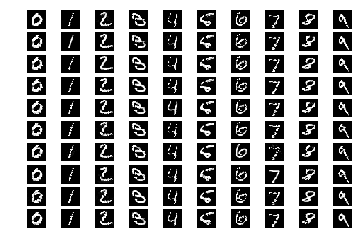

SystemExit: 

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:



def mnist_tutorial_cw(train_start=0, train_end=60000, test_start=0,
                      test_end=10000, viz_enabled=True, nb_epochs=6,
                      batch_size=128, nb_classes=10, source_samples=10,
                      learning_rate=0.001, attack_iterations=10,
                      model_path=os.path.join("models", "mnist"),
                      targeted=True):
    
    """
    MNIST tutorial for Carlini and Wagner's attack
    :param train_start: index of first training set example
    :param train_end: index of last training set example
    :param test_start: index of first test set example
    :param test_end: index of last test set example
    :param viz_enabled: (boolean) activate plots of adversarial examples
    :param nb_epochs: number of epochs to train model
    :param batch_size: size of training batches
    :param nb_classes: number of output classes
    :param source_samples: number of test inputs to attack
    :param learning_rate: learning rate for training
    :param model_path: path to the model file
    :param targeted: should we run a targeted attack? or untargeted?
    :return: an AccuracyReport object
    """
    # Object used to keep track of (and return) key accuracies
    report = AccuracyReport()

    # MNIST-specific dimensions
    img_rows = 28
    img_cols = 28
    channels = 1

    # Set TF random seed to improve reproducibility
    tf.set_random_seed(1234)

    # Create TF session
    sess = tf.Session()
    print("Created TensorFlow session.")

    set_log_level(logging.DEBUG)

    # Get MNIST test data
    X_train, Y_train, X_test, Y_test = data_mnist(train_start=train_start,
                                                  train_end=train_end,
                                                  test_start=test_start,
                                                  test_end=test_end)

    # Define input TF placeholder
    x = tf.placeholder(tf.float32, shape=(None, img_rows, img_cols, channels))
    y = tf.placeholder(tf.float32, shape=(None, nb_classes))

    # Define TF model graph
    model = make_basic_cnn()
    preds = model(x)
    print("Defined TensorFlow model graph.")

    ###########################################################################
    # Training the model using TensorFlow
    ###########################################################################

    # Train an MNIST model
    train_params = {
        'nb_epochs': nb_epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'train_dir': os.path.join(*os.path.split(model_path)[:-1]),
        'filename': os.path.split(model_path)[-1]
    }

    rng = np.random.RandomState([2017, 8, 30])
    # check if we've trained before, and if we have, use that pre-trained model
#     if os.path.exists(model_path + ".meta"):
#         tf_model_load(sess, model_path)
#     else:
    model_train(sess, x, y, preds, X_train, Y_train, args=train_params,
                save=os.path.exists("models"), rng=rng)

    # Evaluate the accuracy of the MNIST model on legitimate test examples
    eval_params = {'batch_size': batch_size}
    accuracy = model_eval(sess, x, y, preds, X_test, Y_test, args=eval_params)
    assert X_test.shape[0] == test_end - test_start, X_test.shape
    print('Test accuracy on legitimate test examples: {0}'.format(accuracy))
    report.clean_train_clean_eval = accuracy

    ###########################################################################
    # Craft adversarial examples using Carlini and Wagner's approach
    ###########################################################################
    nb_adv_per_sample = str(nb_classes - 1) if targeted else '1'
    print('Crafting ' + str(source_samples) + ' * ' + nb_adv_per_sample +
          ' adversarial examples')
    print("This could take some time ...")

    # Instantiate a CW attack object
    cw = CarliniWagnerL2(model, back='tf', sess=sess)

    if viz_enabled:
        assert source_samples == nb_classes
        idxs = [np.where(np.argmax(Y_test, axis=1) == i)[0][0]
                for i in range(nb_classes)]
    if targeted:
        if viz_enabled:
            # Initialize our array for grid visualization
            grid_shape = (nb_classes, nb_classes, img_rows, img_cols, channels)
            grid_viz_data = np.zeros(grid_shape, dtype='f')

            adv_inputs = np.array(
                [[instance] * nb_classes for instance in X_test[idxs]],
                dtype=np.float32)
        else:
            adv_inputs = np.array(
                [[instance] * nb_classes for
                 instance in X_test[:source_samples]], dtype=np.float32)

        one_hot = np.zeros((nb_classes, nb_classes))
        one_hot[np.arange(nb_classes), np.arange(nb_classes)] = 1

        adv_inputs = adv_inputs.reshape(
            (source_samples * nb_classes, img_rows, img_cols, 1))
        adv_ys = np.array([one_hot] * source_samples,
                          dtype=np.float32).reshape((source_samples *
                                                     nb_classes, nb_classes))
        yname = "y_target"
    else:
        if viz_enabled:
            # Initialize our array for grid visualization
            grid_shape = (nb_classes, 2, img_rows, img_cols, channels)
            grid_viz_data = np.zeros(grid_shape, dtype='f')

            adv_inputs = X_test[idxs]
        else:
            adv_inputs = X_test[:source_samples]

        adv_ys = None
        yname = "y"

    cw_params = {'binary_search_steps': 1,
                 yname: adv_ys,
                 'max_iterations': attack_iterations,
                 'learning_rate': 0.1,
                 'batch_size': source_samples * nb_classes if
                 targeted else source_samples,
                 'initial_const': 10}

    adv = cw.generate_np(adv_inputs,
                         **cw_params)

    eval_params = {'batch_size': np.minimum(nb_classes, source_samples)}
    if targeted:
        adv_accuracy = model_eval(
            sess, x, y, preds, adv, adv_ys, args=eval_params)
    else:
        if viz_enabled:
            adv_accuracy = 1 - \
                model_eval(sess, x, y, preds, adv, Y_test[
                           idxs], args=eval_params)
        else:
            adv_accuracy = 1 - \
                model_eval(sess, x, y, preds, adv, Y_test[
                           :source_samples], args=eval_params)

    if viz_enabled:
        for j in range(nb_classes):
            if targeted:
                for i in range(nb_classes):
                    grid_viz_data[i, j] = adv[i * nb_classes + j]
            else:
                grid_viz_data[j, 0] = adv_inputs[j]
                grid_viz_data[j, 1] = adv[j]

        print(grid_viz_data.shape)

    print('--------------------------------------')

    # Compute the number of adversarial examples that were successfully found
    print('Avg. rate of successful adv. examples {0:.4f}'.format(adv_accuracy))
    report.clean_train_adv_eval = 1. - adv_accuracy

    # Compute the average distortion introduced by the algorithm
    percent_perturbed = np.mean(np.sum((adv - adv_inputs)**2,
                                       axis=(1, 2, 3))**.5)/784
    print('Avg. L_2 norm of perturbations score {0:.4f}'.format(percent_perturbed))

    # Close TF session
    sess.close()

    # Finally, block & display a grid of all the adversarial examples
    if viz_enabled:
        import matplotlib.pyplot as plt
        _ = grid_visual(grid_viz_data)

    return report


def main(argv=None):
    mnist_tutorial_cw(viz_enabled=FLAGS.viz_enabled,
                      nb_epochs=18,
                      batch_size=FLAGS.batch_size,
                      nb_classes=FLAGS.nb_classes,
                      source_samples=FLAGS.source_samples,
                      learning_rate=FLAGS.learning_rate,
                      attack_iterations=100,
                      model_path=FLAGS.model_path,
                      targeted=True)
# FLAGS.nb_epochs

if __name__ == '__main__':
    flags.DEFINE_boolean('viz_enabled', True, 'Visualize adversarial ex.')
    flags.DEFINE_integer('nb_epochs',0, 'Number of epochs to train model')
    flags.DEFINE_integer('batch_size', 128, 'Size of training batches')
    flags.DEFINE_integer('nb_classes', 10, 'Number of output classes')
    flags.DEFINE_integer('source_samples', 10, 'Nb of test inputs to attack')
    flags.DEFINE_float('learning_rate', 0.001, 'Learning rate for training')
    flags.DEFINE_string('model_path', os.path.join("models", "mnist"),
                        'Path to save or load the model file')
    flags.DEFINE_boolean('attack_iterations', 100,
                         'Number of iterations to run attack; 1000 is good')
    flags.DEFINE_boolean('targeted', True,
                         'Run the tutorial in targeted mode?')

    tf.app.run()